

---



---


# EWC on the GTSRB dataset



---


- data loaders
- Incremental learning using EWC




In [ ]:
####################################
### Useful imports
############################

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.transforms import v2
import copy

import numpy as np
import random
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# # Useful if you want to store intermediate results on your drive
# from google.colab import drive

# # Useful if you want to store intermediate results on your drive from google.colab import drive

# drive.mount('/content/gdrive/')
# DATA_DIR =  '/content/gdrive/MyDrive/teaching/ENSTA/2024'


Mounted at /content/gdrive/


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
  !nvidia-smi

Sun Mar  9 10:29:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data loaders

In [ ]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
])

transform_train = v2.Compose([
    #v2.Grayscale(),
    #v2.RandomResizedCrop(32),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

# Define dataset and dataloader
def get_dataset(root_dir, transform, train=True):
    dataset = datasets.GTSRB(root=root_dir, split='train' if train else 'test', download=True, transform=transform)
    target = [data[1] for data in dataset]
    return dataset, target

def create_dataloader(dataset, targets, current_classes, batch_size, shuffle):
    indices = [i for i, label in enumerate(targets) if label in current_classes]
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [ ]:
# Loads datasets (on your local computer)
# root_dir = '/home/stephane/Documents/Onera/Cours/ENSTA/2025/data'

# Loads datasets (on Colab local computer)
root_dir = './data'

train_dataset = datasets.GTSRB(root=root_dir, split='train', download=True, transform=transform_train)
test_dataset = datasets.GTSRB(root=root_dir, split='test', download=True, transform=transform_test)

print(f"Train dataset contains {len(train_dataset)} images")
print(f"Test dataset contains {len(test_dataset)} images")

# Loads target id lists and class names (not in torchvision dataset)
import csv
data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/test_target.csv', delimiter=',', header=None)
test_target = data.to_numpy().squeeze().tolist()

data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/train_target.csv', delimiter=',', header=None)
train_target = data.to_numpy().squeeze().tolist()

data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/signnames.csv')
class_names = data['SignName'].tolist()

100%|██████████| 187M/187M [00:08<00:00, 23.0MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 89.0M/89.0M [00:05<00:00, 16.3MB/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 219kB/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb
Train dataset contains 26640 images
Test dataset contains 12630 images


## Display of images

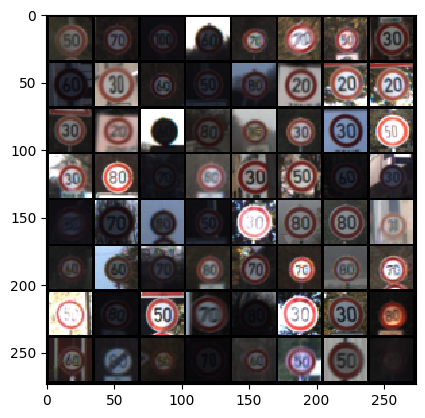

torch.Size([64, 3, 32, 32])


In [ ]:
nclasses = len(np.unique(train_target))
all_classes = list(range(nclasses))
#random.shuffle(all_classes)
classes_per_task = 8
current_classes = []

task = 0
task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
current_classes.extend(task_classes)
batch_size = 64

# Create data for first task
train_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)
test_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)

# Displays a few examples
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(train_loader))
show(make_grid(sample))
plt.show()

print(sample.shape)     ## 64 is the batch
                        ## 1 for grey values --  3 for RGB
                        ## 32x32 for mage size (small here)


In [ ]:
test_loader = create_dataloader(train_dataset, train_target, all_classes, batch_size, shuffle = True)

# Get the data from the test set and computes statistics
# gtsrbtest_gt = []
# for _, targets in test_loader:
#   gtsrbtest_gt += targets.numpy().tolist()
# print(len(gtsrbtest_gt))

from collections import Counter

label_counts = Counter(test_target).most_common()
for l, c in label_counts:
    print(c, '\t', l, '\t', class_names[l])

750 	 2 	 Speed limit (50km/h)
720 	 1 	 Speed limit (30km/h)
720 	 13 	 Yield
690 	 38 	 Keep right
690 	 12 	 Priority road
660 	 4 	 Speed limit (70km/h)
660 	 10 	 No passing for vechiles over 3.5 metric tons
630 	 5 	 Speed limit (80km/h)
480 	 25 	 Road work
480 	 9 	 No passing
450 	 7 	 Speed limit (100km/h)
450 	 3 	 Speed limit (60km/h)
450 	 8 	 Speed limit (120km/h)
420 	 11 	 Right-of-way at the next intersection
390 	 18 	 General caution
390 	 35 	 Ahead only
360 	 17 	 No entry
270 	 14 	 Stop
270 	 31 	 Wild animals crossing
210 	 33 	 Turn right ahead
210 	 15 	 No vechiles
180 	 26 	 Traffic signals
150 	 16 	 Vechiles over 3.5 metric tons prohibited
150 	 23 	 Slippery road
150 	 30 	 Beware of ice/snow
150 	 28 	 Children crossing
150 	 6 	 End of speed limit (80km/h)
120 	 34 	 Turn left ahead
120 	 22 	 Bumpy road
120 	 36 	 Go straight or right
90 	 21 	 Double curve
90 	 20 	 Dangerous curve to the right
90 	 24 	 Road narrows on the right
90 	 29 	 Bicycles cr

## Single LeNet-based classifier

In [ ]:
class LeNetFeatureExtractor(nn.Module):
    def __init__(self, in_channels=3):
        super(LeNetFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        return x.view(x.size(0), -1)  # Output shape: [B, 400]
class LeNetClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LeNetClassifier, self).__init__()
        self.fc1 = nn.Linear(feature_dim, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)  # No softmax (handled in loss function)

class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.feature_extractor = LeNetFeatureExtractor(in_channels=3)  # Extract features
        self.classifier = LeNetClassifier(feature_dim=400, num_classes=num_classes)  # Classifier

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features first
        x = self.classifier(x)  # Then classify
        return x


In [ ]:
!pip install torchinfo
from torchinfo import summary

# Initialize feature extractor
feature_extractor = LeNetFeatureExtractor(in_channels=3).to(device)

# Print summary for feature extractor
print(summary(feature_extractor, input_size=(batch_size, 3, 32, 32)))

# Initialize classifier (e.g., for 10 classes)
classifier = LeNetClassifier(feature_dim=400, num_classes=10).to(device)

# Print summary for classifier
print(summary(classifier, input_size=(batch_size, 400)))

#print(model)

Layer (type:depth-idx)                   Output Shape              Param #
LeNetFeatureExtractor                    [64, 400]                 --
├─Conv2d: 1-1                            [64, 6, 28, 28]           456
├─BatchNorm2d: 1-2                       [64, 6, 28, 28]           12
├─MaxPool2d: 1-3                         [64, 6, 14, 14]           --
├─Conv2d: 1-4                            [64, 16, 10, 10]          2,416
├─BatchNorm2d: 1-5                       [64, 16, 10, 10]          32
├─MaxPool2d: 1-6                         [64, 16, 5, 5]            --
Total params: 2,916
Trainable params: 2,916
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 38.35
Input size (MB): 0.79
Forward/backward pass size (MB): 6.46
Params size (MB): 0.01
Estimated Total Size (MB): 7.25
Layer (type:depth-idx)                   Output Shape              Param #
LeNetClassifier                          [64, 10]                  --
├─Linear: 1-1                            [64, 120]            

## Incremental learning using EWC


In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler
from tqdm import tqdm
import torch.nn.init as init

# Function to evaluate model accuracy
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, ncols=80, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Function to train the model with EWC loss
def train_ewc(model, train_loader, optimizer, criterion, fisher_dict, prev_params, lambda_ewc, device, epoch):
    model.train()
    for images, labels in tqdm(train_loader, ncols=80, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Apply EWC Regularization
        if fisher_dict and prev_params:
            loss += ewc_loss(model, fisher_dict, prev_params, lambda_ewc)

        loss.backward()
        optimizer.step()

# Function to initialize weights using Xavier/Glorot initialization
def initialize_weights(module):
    if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        init.xavier_uniform_(module.weight)  # Xavier initialization
        if module.bias is not None:
            init.zeros_(module.bias)  # Bias set to zero
    elif isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)):
        if module.weight is not None:
            init.ones_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)

# Compute Fisher Information Matrix for EWC
def compute_fisher_information(model, dataloader, criterion, device):
    fisher_dict = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_dict[name] += param.grad ** 2
    for name in fisher_dict:
        fisher_dict[name] /= len(dataloader)
    return fisher_dict

# Function to compute EWC loss
def ewc_loss(model, fisher_dict, prev_params, lambda_ewc):
    loss_reg = 0
    for name, param in model.named_parameters():
        if "fc3" in name:  #  Ignore dynamically changing classifier layer
            continue
        loss_reg += torch.sum(fisher_dict[name] * (param - prev_params[name]) ** 2)
    return lambda_ewc * loss_reg

# Main Incremental Learning with EWC
def incremental_learning_ewc(model, train_dataset, train_target, test_dataset, test_target,
                             num_tasks, classes_per_task, batch_size, num_epochs, lr, lambda_ewc, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    fisher_dict, prev_params = None, None
    current_classes = []
    accuracies = []

    for task in range(num_tasks):
        print(f"\nStarting Task {task+1}/{num_tasks}")

        # Select classes for this task
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        # Create train & test loaders
        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)

        # Expand classifier output size for new classes
        if task == 0 or non_incremental:
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
        else:
            old_weight = model.classifier.fc3.weight.data
            old_bias = model.classifier.fc3.bias.data
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
            model.classifier.fc3.weight.data[:len(old_weight)] = old_weight
            model.classifier.fc3.bias.data[:len(old_bias)] = old_bias

        # Define optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        # Training phase
        for epoch in range(num_epochs):
            train_ewc(model, train_loader, optimizer, criterion, fisher_dict, prev_params, lambda_ewc, device, epoch)
            scheduler.step()
            accuracy_train = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy_train:.2f}%")

        # Compute Fisher Information for EWC
        fisher_dict = compute_fisher_information(model, train_loader, criterion, device)

        # Store previous task weights
        prev_params = {name: param.clone().detach() for name, param in model.named_parameters()}

        # Evaluate model after learning the task
        accuracy_test = evaluate(model, test_loader, device)
        accuracies.append(accuracy_test)
        print(f"Task {task+1}: Accuracy Test = {accuracy_test:.2f}%")

    return accuracies






## Incremental Learning Using Replay Memory Buffer


In [ ]:
import random

class RehearsalBuffer:
    def __init__(self, buffer_size=500):
        self.buffer_size = buffer_size
        self.memory = []  # Stores (image, label) pairs

    def add_samples(self, images, labels):
        """
        Add new samples to the buffer.
        """
        # Convert tensors to lists for easier storage
        images, labels = images.cpu().tolist(), labels.cpu().tolist()
        self.memory.extend(list(zip(images, labels)))

        # Keep buffer size fixed (FIFO strategy)
        if len(self.memory) > self.buffer_size:
            self.memory = self.memory[-self.buffer_size:]  # Keep only latest samples

    def sample(self, batch_size):
        """
        Retrieve a batch of stored samples.
        """
        if len(self.memory) < batch_size:
            return None  # Not enough samples yet
        sampled_data = random.sample(self.memory, batch_size)
        images, labels = zip(*sampled_data)
        return torch.tensor(images), torch.tensor(labels)

def track_buffer_variation(buffer):
    """
    Print the class distribution of samples in the buffer.
    """
    from collections import Counter

    class_counts = Counter(label for _, label in buffer.memory)
    print("📊 Buffer Class Distribution:", class_counts)
def train_with_replay(model, train_loader, optimizer, criterion, buffer, device, epoch):
    """
    Train model using memory replay buffer.
    """
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass for new data
        outputs = model(images)
        loss = criterion(outputs, labels)

        # **🔹 Add Replay from Memory Buffer**
        replay_data = buffer.sample(batch_size=len(images)//2)  # Use 50% new, 50% old
        if replay_data:
            replay_images, replay_labels = replay_data
            replay_images, replay_labels = replay_images.to(device), replay_labels.to(device)
            replay_outputs = model(replay_images)
            replay_loss = criterion(replay_outputs, replay_labels)
            loss += 0.5 * replay_loss  # Weighted mix of new + old loss

        loss.backward()
        optimizer.step()

def incremental_learning_replay(model, train_dataset, train_target, test_dataset, test_target,
                                num_tasks, classes_per_task, batch_size, num_epochs, lr, buffer_size, device):
    """
    Incremental learning with memory replay.
    """
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    buffer = RehearsalBuffer(buffer_size=buffer_size)  # Initialize Memory Buffer
    current_classes = []
    accuracies = []

    for task in range(num_tasks):
        print(f"\nStarting Task {task+1}/{num_tasks}")

        # Select task classes
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        # Create train & test dataloaders
        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)

        # Expand classifier output size for new classes
        if task == 0:
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
        else:
            # Save old weights
            old_weight = model.classifier.fc3.weight.data
            old_bias = model.classifier.fc3.bias.data

            # Expand fc3 for new classes
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
            model.classifier.fc3.weight.data[:len(old_weight)] = old_weight
            model.classifier.fc3.bias.data[:len(old_bias)] = old_bias

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        # Training phase with replay
        for epoch in range(num_epochs):
            train_with_replay(model, train_loader, optimizer, criterion, buffer, device, epoch)
            scheduler.step()
            accuracy_train = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy_train:.2f}%")

        # Store new task data in memory buffer
        for images, labels in train_loader:
            buffer.add_samples(images, labels)
        # Check Buffer Variation
        track_buffer_variation(buffer)
        # Evaluate test accuracy after task training
        accuracy_test = evaluate(model, test_loader, device)
        accuracies.append(accuracy_test)
        print(f"Task {task+1}: Accuracy Test = {accuracy_test:.2f}%")

    return accuracies

## Incremental Learning Replay + EWC

In [ ]:
def train_with_replay_ewc(model, train_loader, optimizer, criterion, buffer, fisher_dict, prev_params, lambda_ewc, device, epoch):
    """
    Train model using both Memory Replay and EWC regularization.
    """
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # 🔹 Forward pass for new data
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 🔹 **Add Replay Buffer Loss**
        replay_data = buffer.sample(batch_size=len(images)//2)  # 50% new, 50% old
        if replay_data:
            replay_images, replay_labels = replay_data
            replay_images, replay_labels = replay_images.to(device), replay_labels.to(device)
            replay_outputs = model(replay_images)
            replay_loss = criterion(replay_outputs, replay_labels)
            loss += 0.5 * replay_loss  # Weighted mix of new + old loss

        # 🔹 **Add EWC Loss**
        if fisher_dict and prev_params:
            loss += lambda_ewc * ewc_loss(model, fisher_dict, prev_params, lambda_ewc)

        loss.backward()
        optimizer.step()


def incremental_learning_replay_ewc(model, train_dataset, train_target, test_dataset, test_target,
                                    num_tasks, classes_per_task, batch_size, num_epochs, lr,
                                    buffer_size, lambda_ewc, device):
    """
    Incremental Learning using both **Replay Buffer** and **EWC Regularization**.
    """
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    buffer = RehearsalBuffer(buffer_size=buffer_size)  #  Initialize Memory Buffer
    fisher_dict, prev_params = None, None
    current_classes = []
    accuracies = []

    for task in range(num_tasks):
        print(f"\n Starting Task {task+1}/{num_tasks}")

        # Select task classes
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        # Create train & test dataloaders
        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)

        # Expand classifier output size for new classes
        if task == 0:
            model.fc3 = nn.Linear(model.fc3.in_features, len(current_classes)).to(device)
        else:
            old_weight = model.fc3.weight.data
            old_bias = model.fc3.bias.data

            model.fc3 = nn.Linear(model.fc3.in_features, len(current_classes)).to(device)
            model.fc3.weight.data[:len(old_weight)] = old_weight
            model.fc3.bias.data[:len(old_bias)] = old_bias

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        #  Training with Replay + EWC
        for epoch in range(num_epochs):
            train_with_replay_ewc(model, train_loader, optimizer, criterion, buffer, fisher_dict, prev_params, lambda_ewc, device, epoch)
            scheduler.step()
            accuracy_train = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy_train:.2f}%")

        # Store new task data in memory buffer
        for images, labels in train_loader:
            buffer.add_samples(images, labels)

        # Compute Fisher Information for EWC
        fisher_dict = compute_fisher_information(model, train_loader, criterion, device)

        # Store previous task weights
        prev_params = {name: param.clone().detach() for name, param in model.named_parameters()}

        # Evaluate model after learning the task
        accuracy_test = evaluate(model, test_loader, device)
        accuracies.append(accuracy_test)
        print(f"Task {task+1}: Accuracy Test = {accuracy_test:.2f}%")

    return accuracies


## Weight & Biases (Wandb)

You can use this environement to log your learning.

The code below provides a version of the class incremental function that stores learning curves and the seauence of accuracies for each increment of classes.

Tu use it, create an account at: https://wandb.ai/

In [ ]:
###################################
##### For using Weight & Biases
###############

!pip install wandb -qU

import wandb

wandb.login()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 99.2 MB/s eta 0:00:00


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sebasangarita (sebasangarita-institut-d-optique-graduate-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## EWC Wandb

In [ ]:
import math
# Simple Training loop
# Function to train the model with EWC loss and log to wandb
def train_ewc_wandb(model, train_loader, optimizer, criterion, fisher_dict, prev_params, lambda_ewc, device, epoch):
    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Apply EWC Regularization
        if fisher_dict and prev_params:
            loss += ewc_loss(model, fisher_dict, prev_params, lambda_ewc)

        loss.backward()
        optimizer.step()

        # Log training loss
        metrics = {"train/train_loss": loss.item()}
        if step + 1 < n_steps_per_epoch:
            wandb.log(metrics)
        step_ct += 1


# Main training loop for incremental learning
def incremental_learning_ewc_wandb(model, train_dataset, train_target, test_dataset, test_target,
                                   num_tasks, classes_per_task, batch_size, num_epochs, lr, lambda_ewc,
                                   device, non_incremental=False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    fisher_dict, prev_params = None, None
    current_classes = []
    accuracies = []

    # Initialize wandb logging
    wandb.init(project="incremental-learning-ewc")
    config = wandb.config
    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        print(f"\n Starting Task {task+1}/{num_tasks}")

        # Non-incremental baseline (learns from all available data)
        if non_incremental:
            task_classes = all_classes[0 : (task + 1) * classes_per_task]
            current_classes = task_classes
            model.apply(initialize_weights)
        else:
            task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
            current_classes.extend(task_classes)

        # Create train & test data loaders
        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)

        # Expand classifier output size for new classes
        if task == 0 or non_incremental:
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
        else:
            old_weight = model.classifier.fc3.weight.data
            old_bias = model.classifier.fc3.bias.data
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
            model.classifier.fc3.weight.data[:len(old_weight)] = old_weight
            model.classifier.fc3.bias.data[:len(old_bias)] = old_bias

        # Define optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        # Training phase
        for epoch in range(num_epochs):
            train_ewc_wandb(model, train_loader, optimizer, criterion, fisher_dict, prev_params, lambda_ewc, device, epoch)
            scheduler.step()
            accuracy_train = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy_train:.2f}%")

            # Log validation accuracy
            val_metrics = {"val/val_accuracy": accuracy_train}
            wandb.log(val_metrics)

        # Compute Fisher Information for EWC
        fisher_dict = compute_fisher_information(model, train_loader, criterion, device)
        # Store previous task weights
        prev_params = {name: param.clone().detach() for name, param in model.named_parameters()}

        # Evaluate model after learning the task
        accuracy_test = evaluate(model, test_loader, device)
        accuracies.append(accuracy_test)
        print(f" Task {task+1}: Accuracy Test = {accuracy_test:.2f}%")

        # Log incremental accuracy to wandb
        incremental_metrics = {"incremental_accuracy": accuracy_test, "task": task}
        wandb.log(incremental_metrics)

    return accuracies

## Replay Wandb

In [ ]:
import math

# Simple Training loop
# Function to train the model with EWC loss and log to wandb
def train_with_replay_wandb(model, train_loader, optimizer, criterion, buffer, device, epoch):
    """
    """
    model.train()
    step_ct = 0
    n_steps_per_epoch = len(train_loader)

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass for new data
        outputs = model(images)
        loss = criterion(outputs, labels)

        # **🔹 Add Replay from Memory Buffer**
        replay_data = buffer.sample(batch_size=len(images)//2)  # Use 50% new, 50% old
        if replay_data:
            replay_images, replay_labels = replay_data
            replay_images, replay_labels = replay_images.to(device), replay_labels.to(device)
            replay_outputs = model(replay_images)
            replay_loss = criterion(replay_outputs, replay_labels)
            loss += 0.5 * replay_loss  # Weighted mix of new + old loss

        loss.backward()
        optimizer.step()

        # Log loss to WandB
        wandb.log({"train/train_loss": loss.item(), "step": step + epoch * n_steps_per_epoch})
        step_ct += 1



# Main training loop for incremental learning
import wandb

def incremental_learning_replay_wandb(model, train_dataset, train_target, test_dataset, test_target,
                                      num_tasks, classes_per_task, batch_size, num_epochs, lr,
                                      buffer_size, device, non_incremental=False):
    """
    Incremental Learning with Replay Buffer & WandB logging.

    - Stores a **memory buffer** of past tasks to prevent forgetting.
    - Uses **WandB** to track progress across tasks.
    """
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    buffer = RehearsalBuffer(buffer_size=buffer_size)  # Initialize Memory Buffer
    current_classes = []
    accuracies = []

    # Initialize WandB Logging
    wandb.init(project="incremental-learning-replay", name="Replay_Training")
    config = wandb.config
    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        print(f"\n Starting Task {task+1}/{num_tasks}")

        # Non-incremental baseline (learns from all available data)
        if non_incremental:
            task_classes = all_classes[0 : (task + 1) * classes_per_task]
            current_classes = task_classes
            model.apply(initialize_weights)
        else:
            task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
            current_classes.extend(task_classes)

        # Create train & test dataloaders
        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)

        # Expand classifier output size for new classes
        if task == 0 or non_incremental:
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
        else:
            # Save old weights
            old_weight = model.classifier.fc3.weight.data
            old_bias = model.classifier.fc3.bias.data

            # Expand fc3 for new classes
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
            model.classifier.fc3.weight.data[:len(old_weight)] = old_weight
            model.classifier.fc3.bias.data[:len(old_bias)] = old_bias

        # Optimizer and Scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        # Training phase with replay
        for epoch in range(num_epochs):
            train_with_replay(model, train_loader, optimizer, criterion, buffer, device, epoch)
            scheduler.step()
            accuracy_train = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy_train:.2f}%")

            # Log train accuracy
            wandb.log({"train/train_accuracy": accuracy_train, "epoch": epoch})

        # Store new task data in memory buffer
        for images, labels in train_loader:
            buffer.add_samples(images, labels)
        # Check Buffer Variation
        track_buffer_variation(buffer)
        # Evaluate test accuracy after task training
        accuracy_test = evaluate(model, test_loader, device)
        accuracies.append(accuracy_test)
        print(f"Task {task+1}: Accuracy Test = {accuracy_test:.2f}%")

        # Log incremental accuracy to WandB
        incremental_metrics = {"incremental_accuracy": accuracy_test, "task": task}
        wandb.log(incremental_metrics)

    return accuracies




## Replay + EWC

In [ ]:
def train_with_replay_ewc_wandb(model, train_loader, optimizer, criterion, buffer, fisher_dict, prev_params, lambda_ewc, device, epoch):
    """
    Train model using both Memory Replay and EWC regularization, while logging to WandB.
    """
    model.train()
    step_ct = 0
    n_steps_per_epoch = len(train_loader)

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        #  Forward pass for new data
        outputs = model(images)
        loss = criterion(outputs, labels)

        # **Add Replay Buffer Loss**
        replay_data = buffer.sample(batch_size=len(images)//2)  # 50% new, 50% old
        if replay_data:
            replay_images, replay_labels = replay_data
            replay_images, replay_labels = replay_images.to(device), replay_labels.to(device)
            replay_outputs = model(replay_images)
            replay_loss = criterion(replay_outputs, replay_labels)
            loss += 0.5 * replay_loss  # Weighted mix of new + old loss

        # **Add EWC Loss**
        if fisher_dict and prev_params:
            loss += lambda_ewc * ewc_loss(model, fisher_dict, prev_params, lambda_ewc)

        loss.backward()
        optimizer.step()

        # Log to WandB
        wandb.log({"train/loss": loss.item(), "train/step": step + epoch * n_steps_per_epoch})
        step_ct += 1

def incremental_learning_replay_ewc_wandb(model, train_dataset, train_target, test_dataset, test_target,
                                          num_tasks, classes_per_task, batch_size, num_epochs, lr,
                                          buffer_size, lambda_ewc, device, non_incremental = False):
    """
    Incremental Learning using both **Replay Buffer** and **EWC Regularization**, tracked in WandB.
    """
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    buffer = RehearsalBuffer(buffer_size=buffer_size)  #  Initialize Memory Buffer
    fisher_dict, prev_params = None, None
    current_classes = []
    accuracies = []

    # Initialize WandB Logging
    wandb.init(project="incremental-learning-replay-ewc", name="Replay + EWC")
    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        print(f"\n Starting Task {task+1}/{num_tasks}")

        # Select task classes
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        # Create train & test dataloaders
        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)

        # Expand classifier output size for new classes
        if task == 0 or non_incremental:
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
        else:
            # Save old weights
            old_weight = model.classifier.fc3.weight.data
            old_bias = model.classifier.fc3.bias.data

            # Expand fc3 for new classes
            model.classifier.fc3 = nn.Linear(model.classifier.fc3.in_features, len(current_classes)).to(device)
            model.classifier.fc3.weight.data[:len(old_weight)] = old_weight
            model.classifier.fc3.bias.data[:len(old_bias)] = old_bias


        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        #  Training with Replay + EWC
        for epoch in range(num_epochs):
            train_with_replay_ewc_wandb(model, train_loader, optimizer, criterion, buffer, fisher_dict, prev_params, lambda_ewc, device, epoch)
            scheduler.step()
            accuracy_train = evaluate(model, train_loader, device)
            print(f" Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy_train:.2f}%")

            # Log Train Accuracy
            wandb.log({"train/train_accuracy": accuracy_train, "epoch": epoch})

        # Store new task data in memory buffer
        for images, labels in train_loader:
            buffer.add_samples(images, labels)

        # Compute Fisher Information for EWC
        fisher_dict = compute_fisher_information(model, train_loader, criterion, device)

        # Store previous task weights
        prev_params = {name: param.clone().detach() for name, param in model.named_parameters()}

        # Evaluate model after learning the task
        accuracy_test = evaluate(model, test_loader, device)
        accuracies.append(accuracy_test)
        print(f"📊 Task {task+1}: Accuracy Test = {accuracy_test:.2f}%")

        # Log Test Accuracy to WandB
        wandb.log({"incremental_accuracy": accuracy_test, "task": task})

    wandb.finish()
    return accuracies


## Pre-Training

In [ ]:
import os
import copy
import torch

# Hyperparameters
root_dir = './data'  # Path to GTSRB dataset
num_tasks = 5
numclasses = len(np.unique(train_target))
classes_per_task = numclasses // num_tasks  # ~8 classes per task
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

buffer_size = 200  # Adjust rehearsal set size
alignment_strength = 0.1  # Adjust alignment strength
num_epochs = 4  # Number of pretraining epochs
lambda_ewc = 5.0  # Strength of EWC regularization

# Choose model type and filename for saving
tag = "LeNet_GTSRB_pretrained_EWC"  # Change if using a different model
netname = os.path.join(root_dir, f'network_{tag}.pth')

#################################################
## Pre-training Step
####

# Read the last learned network (if stored)
if os.path.exists(netname):
    print('Loading pre-trained network...')
    model = LeNet(num_classes=classes_per_task)  # Use the full model (Feature Extractor + Classifier)
    model.load_state_dict(torch.load(netname, map_location=device))
    model.to(device)
else:
    print('Pretraining new model...')
    model = LeNet(num_classes=classes_per_task)  # Use full model
    model.apply(initialize_weights)
    model.to(device)

    # Initialize wandb logging
    wandb.init(project="incremental-learning-ewc", name="pretraining")

    # Run incremental learning with EWC on first task
    accu = incremental_learning_replay(model, train_dataset, train_target, test_dataset, test_target,
                                          num_tasks=1, classes_per_task=classes_per_task,
                                          batch_size=batch_size, num_epochs=num_epochs,
                                          lr=lr, device=device)

    print(f"Pre-training completed! Accuracy on first task = {accu[0]:.2f}%")

    # Save the pre-trained model
    torch.save(model.state_dict(), netname)

# Copy model to ensure same initialization for incremental learning
copy_model = copy.deepcopy(model)

#### Adjust number of epochs for incremental learning
num_epochs = 1  # Faster incremental learning, but may reduce accuracy


Loading pre-trained network...


<ipython-input-22-c34b115af53c>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(netname, map_location=device))




## Incremental learning Initialization

In [ ]:
#############################################
##

# Initialize a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name="Replay+EWC 2",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        "lambda_ewc": lambda_ewc,  # Logging EWC regularization strength
    }
)

# Load model from pretraining
model = copy.deepcopy(copy_model)  # Use the model copy from pretraining

"""# Main training loop for incremental learning
incremental_learning_replay_wandb(model, train_dataset, train_target, test_dataset, test_target,
                               num_tasks=num_tasks, classes_per_task=classes_per_task,
                               batch_size=batch_size, num_epochs=num_epochs,
                               lr=lr, buffer_size=200,device=device)"""
num_epochs = 5  # Reduce for faster testing
buffer_size = 1000  # Experiment with different sizes
lambda_ewc = 1  # Strength of EWC penalty

accuracies = incremental_learning_replay_ewc_wandb(model, train_dataset, train_target, test_dataset, test_target,
                                                   num_tasks=num_tasks, classes_per_task=classes_per_task,
                                                   batch_size=batch_size, num_epochs=num_epochs,
                                                   lr=lr, buffer_size=buffer_size, lambda_ewc=lambda_ewc, device=device, non_incremental = False)
# Finish the wandb run
wandb.finish()



 Starting Task 1/5


Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 35.05it/s]


 Task 1, Epoch 1: Accuracy Train = 97.62%


Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 40.20it/s]


 Task 1, Epoch 2: Accuracy Train = 98.48%


Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 38.84it/s]


 Task 1, Epoch 3: Accuracy Train = 98.87%


Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 41.06it/s]


 Task 1, Epoch 4: Accuracy Train = 98.93%


Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 41.00it/s]


 Task 1, Epoch 5: Accuracy Train = 99.33%


Evaluating: 100%|███████████████████████████████| 61/61 [00:01<00:00, 39.98it/s]


📊 Task 1: Accuracy Test = 93.33%

 Starting Task 2/5


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 38.15it/s]


 Task 2, Epoch 1: Accuracy Train = 95.39%


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 40.11it/s]


 Task 2, Epoch 2: Accuracy Train = 98.23%


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 39.85it/s]


 Task 2, Epoch 3: Accuracy Train = 99.18%


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 39.15it/s]


 Task 2, Epoch 4: Accuracy Train = 99.66%


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 32.71it/s]


 Task 2, Epoch 5: Accuracy Train = 99.58%


Evaluating: 100%|█████████████████████████████| 122/122 [00:03<00:00, 34.07it/s]


📊 Task 2: Accuracy Test = 93.93%

 Starting Task 3/5


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 39.90it/s]


 Task 3, Epoch 1: Accuracy Train = 66.57%


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 39.72it/s]


 Task 3, Epoch 2: Accuracy Train = 93.43%


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 38.88it/s]


 Task 3, Epoch 3: Accuracy Train = 96.73%


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 40.03it/s]


 Task 3, Epoch 4: Accuracy Train = 98.40%


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 39.99it/s]


 Task 3, Epoch 5: Accuracy Train = 99.29%


Evaluating: 100%|█████████████████████████████| 144/144 [00:04<00:00, 33.22it/s]


📊 Task 3: Accuracy Test = 56.02%

 Starting Task 4/5


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 38.84it/s]


 Task 4, Epoch 1: Accuracy Train = 62.86%


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 39.38it/s]


 Task 4, Epoch 2: Accuracy Train = 89.84%


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 32.51it/s]


 Task 4, Epoch 3: Accuracy Train = 95.82%


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 39.68it/s]


 Task 4, Epoch 4: Accuracy Train = 95.82%


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 39.52it/s]


 Task 4, Epoch 5: Accuracy Train = 98.93%


Evaluating: 100%|█████████████████████████████| 167/167 [00:05<00:00, 33.37it/s]


📊 Task 4: Accuracy Test = 28.71%

 Starting Task 5/5


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 40.69it/s]


 Task 5, Epoch 1: Accuracy Train = 88.65%


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 38.82it/s]


 Task 5, Epoch 2: Accuracy Train = 98.20%


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 41.38it/s]


 Task 5, Epoch 3: Accuracy Train = 99.34%


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 40.31it/s]


 Task 5, Epoch 4: Accuracy Train = 99.68%


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 32.18it/s]


 Task 5, Epoch 5: Accuracy Train = 99.66%


Evaluating: 100%|█████████████████████████████| 194/194 [00:04<00:00, 40.05it/s]

📊 Task 5: Accuracy Test = 25.17%


epoch,▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅▆█
incremental_accuracy,██▄▁▁
task,▁▃▅▆█
train/loss,▄▂▁▁▁▁▁▁▁▁▁▁▁▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▆▆▃▃▂▁▂█▃▂▆▁
train/step,▁▂▂▃▄▆▁▁▁▂▃▃▃▃▃▅▅▆▆▆▇▇▇██▂▂▂▃▃▃▄▂▂▃▄▂▂▃▄
train/train_accuracy,█████▇████▂▇▇██▁▆▇▇█▆████
epoch,4
incremental_accuracy,25.16546
task,4
train/loss,0.00735
train/step,299


## Upper bound

In [ ]:
#################################################
## Global upper bound (all data, all classes)
####

# One task + all classes computed using 5 epochs

model = copy.deepcopy(copy_model)
accu = incremental_learning_ewc_wandb(model, train_dataset, train_target, test_dataset, test_target,
                               num_tasks=num_tasks, classes_per_task=classes_per_task,
                               batch_size=batch_size, num_epochs=5, lr=lr, lambda_ewc=lambda_ewc, device=device)

print(f"!!!!! Upper bound of accuracy = {accu[0]:.2f}%")



Starting Task 1/5


Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 34.07it/s]


Task 1, Epoch 1: Accuracy Train = 98.47%


Evaluating: 100%|█████████████████████████████| 125/125 [00:02<00:00, 42.11it/s]


Task 1, Epoch 2: Accuracy Train = 98.91%


Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 33.71it/s]


Task 1, Epoch 3: Accuracy Train = 99.07%


Evaluating: 100%|█████████████████████████████| 125/125 [00:02<00:00, 43.15it/s]


Task 1, Epoch 4: Accuracy Train = 99.48%


Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 33.63it/s]


Task 1, Epoch 5: Accuracy Train = 99.58%


Evaluating: 100%|███████████████████████████████| 61/61 [00:01<00:00, 41.89it/s]


✅ Task 1: Accuracy Test = 93.85%

Starting Task 2/5


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 32.78it/s]


Task 2, Epoch 1: Accuracy Train = 97.99%


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 40.09it/s]


Task 2, Epoch 2: Accuracy Train = 99.51%


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 39.25it/s]


Task 2, Epoch 3: Accuracy Train = 99.81%


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 41.32it/s]


Task 2, Epoch 4: Accuracy Train = 99.85%


Evaluating: 100%|█████████████████████████████| 126/126 [00:03<00:00, 41.98it/s]


Task 2, Epoch 5: Accuracy Train = 99.91%


Evaluating: 100%|█████████████████████████████| 122/122 [00:03<00:00, 40.14it/s]


✅ Task 2: Accuracy Test = 49.60%

Starting Task 3/5


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 37.30it/s]


Task 3, Epoch 1: Accuracy Train = 63.17%


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 40.33it/s]


Task 3, Epoch 2: Accuracy Train = 90.96%


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 42.01it/s]


Task 3, Epoch 3: Accuracy Train = 95.10%


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 41.33it/s]


Task 3, Epoch 4: Accuracy Train = 94.84%


Evaluating: 100%|███████████████████████████████| 49/49 [00:01<00:00, 31.14it/s]


Task 3, Epoch 5: Accuracy Train = 96.12%


Evaluating: 100%|█████████████████████████████| 144/144 [00:03<00:00, 42.08it/s]


✅ Task 3: Accuracy Test = 14.76%

Starting Task 4/5


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 40.97it/s]


Task 4, Epoch 1: Accuracy Train = 61.98%


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 40.94it/s]


Task 4, Epoch 2: Accuracy Train = 80.41%


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 30.98it/s]


Task 4, Epoch 3: Accuracy Train = 95.09%


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 40.05it/s]


Task 4, Epoch 4: Accuracy Train = 97.86%


Evaluating: 100%|███████████████████████████████| 50/50 [00:01<00:00, 41.46it/s]


Task 4, Epoch 5: Accuracy Train = 99.25%


Evaluating: 100%|█████████████████████████████| 167/167 [00:04<00:00, 38.97it/s]


✅ Task 4: Accuracy Test = 12.20%

Starting Task 5/5


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 42.23it/s]


Task 5, Epoch 1: Accuracy Train = 71.61%


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 42.42it/s]


Task 5, Epoch 2: Accuracy Train = 97.38%


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 42.45it/s]


Task 5, Epoch 3: Accuracy Train = 99.07%


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 32.19it/s]


Task 5, Epoch 4: Accuracy Train = 99.68%


Evaluating: 100%|███████████████████████████████| 60/60 [00:01<00:00, 42.98it/s]


Task 5, Epoch 5: Accuracy Train = 99.79%


Evaluating: 100%|█████████████████████████████| 194/194 [00:04<00:00, 42.14it/s]

✅ Task 5: Accuracy Test = 14.70%
!!!!! Upper bound of accuracy = 93.85%


In [ ]:
########################################
## Upper bound for each task (takes some time)
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Upper bound",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Non incremental data (learn all classes from all data for each task)
model = copy.deepcopy(copy_model)

incremental_learning_ewc_wandb(model, train_dataset, train_target, test_dataset, test_target,
                               num_tasks=num_tasks, classes_per_task=classes_per_task,
                               batch_size=batch_size, num_epochs=num_epochs, lr=lr, lambda_ewc=lambda_ewc, device=device, non_incremental = True)

wandb.finish()


 Starting Task 1/5


Epoch 0: 125it [00:03, 33.93it/s]
Evaluating: 100%|█████████████████████████████| 125/125 [00:03<00:00, 35.97it/s]


Task 1, Epoch 1: Accuracy Train = 72.19%


Evaluating: 100%|███████████████████████████████| 61/61 [00:01<00:00, 42.43it/s]


 Task 1: Accuracy Test = 61.86%

 Starting Task 2/5


Epoch 0: 250it [00:08, 30.86it/s]
Evaluating: 100%|█████████████████████████████| 250/250 [00:06<00:00, 38.94it/s]


Task 2, Epoch 1: Accuracy Train = 83.92%


Evaluating: 100%|█████████████████████████████| 122/122 [00:03<00:00, 38.13it/s]


 Task 2: Accuracy Test = 79.33%

 Starting Task 3/5


Epoch 0: 299it [00:09, 32.75it/s]
Evaluating: 100%|█████████████████████████████| 299/299 [00:08<00:00, 36.38it/s]


Task 3, Epoch 1: Accuracy Train = 83.93%


Evaluating: 100%|█████████████████████████████| 144/144 [00:04<00:00, 33.55it/s]


 Task 3: Accuracy Test = 78.44%

 Starting Task 4/5


Epoch 0: 348it [00:11, 29.50it/s]
Evaluating: 100%|█████████████████████████████| 348/348 [00:08<00:00, 40.67it/s]


Task 4, Epoch 1: Accuracy Train = 76.80%


Evaluating: 100%|█████████████████████████████| 167/167 [00:04<00:00, 40.94it/s]


 Task 4: Accuracy Test = 70.21%

 Starting Task 5/5


Epoch 0: 407it [00:12, 32.64it/s]
Evaluating: 100%|█████████████████████████████| 407/407 [00:10<00:00, 38.14it/s]


Task 5, Epoch 1: Accuracy Train = 76.63%


Evaluating: 100%|█████████████████████████████| 194/194 [00:04<00:00, 40.20it/s]

 Task 5: Accuracy Test = 69.98%


incremental_accuracy,█▁▅▅▃▃
task,▁▁▃▅▆█
train/train_loss,▂▂▂▂▂▁▁▁▁▁▃▂▂▂▂▂▂▂▂▁▁▃▄▃▃▂▂▂▂▂▂▅▃▃▃▂█▃▂▂
val/val_accuracy,▁▆▇▇█▅▇▃▅▅▄▄
incremental_accuracy,69.97579
task,4
train/train_loss,1.4583
val/val_accuracy,76.6321
